# Sergio Alejandro Zamora Dávila

Importo los datos del archivo “TiempoDeEntrega.csv” al ambiente de trabajo. Sin embargo a la hora de intentar hacer una gráfica de dispersión para observar el comportamiento de los datos me arrojó varios errores, y una vez revisando la base de datos me di cuenta de que habían valores incorrectos en la base de datos. Tales como: Números negativos (que con el contexto no tiene nada de sentido), datos como "$#%" en la variable Calificación, lo cuál no tiene sentido, ya que solo debería de haber números ahí. Tuve que convertir los datos a entero para ver así cuales eran los que me estaban causando problemas. Además de que una vez resueltos esos problemas y graficarlo me di cuenta de valores demasiado grandes para tener sentido, por lo que se realizo una prueba de Turkey para solucionarlo. Ya con todo esto resuelto, genero una gráfica de dispersión que muestra el comportamiento de los datos.


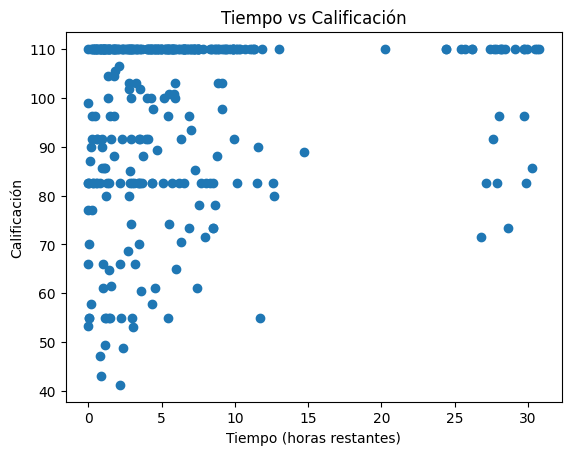

Solo con la gráfica aún no podemos saber cuál será el tipo de algoritmo será el adecuado para simular los datos, sin embargo yo considero que un algoritmo de tipo cuadrado tendrá buenos resultados


In [53]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

df = pd.read_csv("TiempoDeEntrega.csv")

# Convertimos las columnas a numéricas o si no se puede se convierte en NaN
df["Tiempo"] = pd.to_numeric(df["Tiempo"], errors="coerce")
df["Calificacion"] = pd.to_numeric(df["Calificacion"], errors="coerce")

# Hacemos drop a los NaN
df = df.dropna()

# Busco si es que hay datos muy grandes o muy pequeños a comparación de los demás
# Tiempo
Q1_t = df["Tiempo"].quantile(0.25)
Q3_t = df["Tiempo"].quantile(0.75)
IQR_t = Q3_t - Q1_t
lim_inf_t = Q1_t - 1.5 * IQR_t
lim_sup_t = Q3_t + 1.5 * IQR_t

df = df[df["Tiempo"].between(lim_inf_t, lim_sup_t)]

# Calificación 
Q1_c = df["Calificacion"].quantile(0.25)
Q3_c = df["Calificacion"].quantile(0.75)
IQR_c = Q3_c - Q1_c
lim_inf_c = Q1_c - 1.5 * IQR_c
lim_sup_c = Q3_c + 1.5 * IQR_c

df = df[df["Calificacion"].between(lim_inf_c, lim_sup_c)]

# Gráfica de dispersión
plt.scatter(df["Tiempo"], df["Calificacion"])
plt.xlabel("Tiempo (horas restantes)")
plt.ylabel("Calificación")
plt.title("Tiempo vs Calificación")
plt.show()

print("Solo con la gráfica aún no podemos saber cuál será el tipo de algoritmo será el adecuado para simular los datos, sin embargo yo considero que un algoritmo de tipo cuadrado tendrá buenos resultados")


Separo los datos de entrenamiento y prueba, con una relación de 70/30 e imprimo en
consola el promedio de los tiempos y calificaciones en el conjunto de entrenamiento y en el conjunto de
prueba. 

In [60]:
from sklearn.model_selection import train_test_split

X = df[["Tiempo"]]  
y = df["Calificacion"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

print("Promedio Tiempo (train):", X_train["Tiempo"].mean())
print("Promedio Tiempo (test):", X_test["Tiempo"].mean())
print("Promedio Calificación (train):", y_train.mean())
print("Promedio Calificación (test):", y_test.mean())


print("Se obseerva que el tiempo promedio en train y test tiene una diferencia de 1, lo que puede llegar a afectar al análisis, ya que si hay una gran diferencia entre ambos valores el modelo puede tener mayores problemas a la hora de predecir resultados, esto es más notorio en el apartado de Calificación, el cuál tiene una diferencia de 4 puntos entre ambos valores")

Promedio Tiempo (train): 6.145300526892242
Promedio Tiempo (test): 7.21162777773
Promedio Calificación (train): 98.96122181034482
Promedio Calificación (test): 94.45213039999999
Se obseerva que el tiempo promedio en train y test tiene una diferencia de 1, lo que puede llegar a afectar al análisis, ya que si hay una gran diferencia entre ambos valores el modelo puede tener mayores problemas a la hora de predecir resultados, esto es más notorio en el apartado de Calificación, el cuál tiene una diferencia de 4 puntos entre ambos valores


Entreno un modelo de regresión polinomial utilizando los datos de entrenamiento e imprimo un resumen de los
resultados obtenidos

In [55]:
import statsmodels.api as sm
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(degree=2)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

modelo_poly = sm.OLS(y_train, X_train_poly).fit()
print(modelo_poly.summary())

yHat_poly = modelo_poly.predict(X_test_poly)

                            OLS Regression Results                            
Dep. Variable:           Calificacion   R-squared:                       0.055
Model:                            OLS   Adj. R-squared:                  0.047
Method:                 Least Squares   F-statistic:                     6.685
Date:                Sun, 31 Aug 2025   Prob (F-statistic):            0.00151
Time:                        21:52:46   Log-Likelihood:                -978.02
No. Observations:                 232   AIC:                             1962.
Df Residuals:                     229   BIC:                             1972.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         92.9279      1.993     46.625      0.0

En los resultados vemos un valor de 1.6918, por lo que significa que entre mayor tiempo antes de la hora de entrega, hay una mayor calificación esperada, además de que el valor de p es de 0.001, por lo que es estadisticamente significativo.

Sin embargo el valor de x2, el cuadrático es de -0.047 lo que implica que entre más crezca el tiempo realmente la relación no sigue aumentando de una forma lineal. El valor de p es de 0.007, por lo que también es significativo. 

Entreno un modelo de regresión segmentada, utilizando regresiones cuadráticas para cada segmento y genero
predicciones en los datos de validación.

C:\Users\sergi\OneDrive\Escritorio\Lib\site-packages\sklearn\preprocessing\_discretization.py:296: FutureWarning: The current default behavior, quantile_method='linear', will be changed to quantile_method='averaged_inverted_cdf' in scikit-learn version 1.9 to naturally support sample weight equivalence properties by default. Pass quantile_method='averaged_inverted_cdf' explicitly to silence this warning.
  warnings.warn(


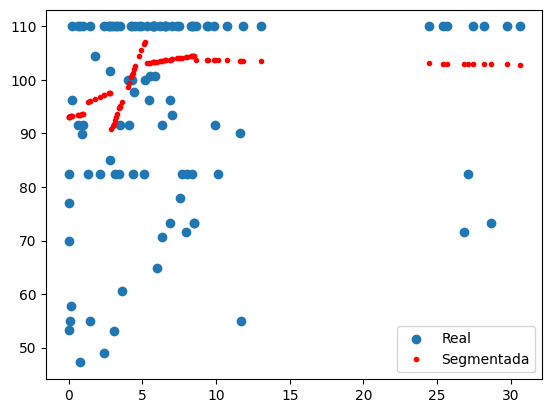

In [56]:
from mlinsights.mlmodel import PiecewiseRegressor

ms = PiecewiseRegressor("bins").fit(X_train, y_train)
yHat_ms = ms.predict(X_test)

plt.scatter(X_test, y_test, label="Real")
plt.plot(X_test, yHat_ms, "r.", label="Segmentada")
plt.legend()
plt.show()



Entreno un modelo KNN para regresión utilizando el valor de k que considere adecuado (un valor de 10) y generé estimaciones en los datos de validación.


In [63]:
from sklearn.neighbors import KNeighborsRegressor

knn = KNeighborsRegressor(n_neighbors=10)
knn.fit(X_train, y_train)
yHat_knn = knn.predict(X_test)

Calcule el RSE en los datos de prueba para los 3 modelos.

In [64]:
import numpy as np

# Polinomial
RSS_poly = sum((y_test - yHat_poly) ** 2)
RSE_poly = np.sqrt(RSS_poly / (len(y_test) - 1))

# Segmentada
RSS_ms = sum((y_test - yHat_ms) ** 2)
RSE_ms = np.sqrt(RSS_ms / (len(y_test) - 1))

# KNN
RSS_knn = sum((y_test - yHat_knn) ** 2)
RSE_knn = np.sqrt(RSS_knn / (len(y_test) - 1))

print("RSE Polinomial:", RSE_poly)
print("RSE Segmentada:", RSE_ms)
print("RSE KNN:", RSE_knn)


RSE Polinomial: 18.853886559715228
RSE Segmentada: 18.882897849463887
RSE KNN: 18.011041401940215


Aunque los 3 modelos tienen unos valores de RSE muy similares, el KNN tiene un mejor valor y se ajusta mejor cuantitativamente hablando. Pero el polinomial es más interpretable, ya que tiene una tendencia clara de crecimiento seguido y tiene una ligera caída, de lo que se puede intuir que existe un punto óptimo de tiempo para entregar la tarea. El modelo Segmentado también tiene este comportamiento, pero este cuenta con quiebres más bruscos, lo que se ve como un sobreajuste y pierde poder de predicción en ciertas partes del modelo. Y el KNN genera una aproximación flexible, esto debido a que no tiene una forma funcional explícita. Aunque el KNN tiene un mejor desempeño en terminos de RSE, el modelo polinomial es más explicativo, por lo que lo considero el "mejor modelo".

Para los datos de prueba, grafique tanto las calificaciones reales como las predichas por los 3 modelos en un mismo plot, utilizando etiquetas, colores distintos, marcadores para diferenciar y describir a cada modelo.

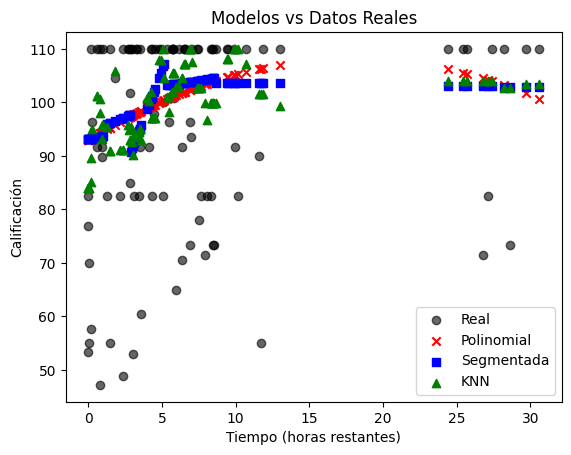

In [65]:
plt.scatter(X_test, y_test, label="Real", color="black", alpha=0.6)
plt.scatter(X_test, yHat_poly, label="Polinomial", color="red", marker="x")
plt.scatter(X_test, yHat_ms, label="Segmentada", color="blue", marker="s")
plt.scatter(X_test, yHat_knn, label="KNN", color="green", marker="^")

plt.xlabel("Tiempo (horas restantes)")
plt.ylabel("Calificación")
plt.title("Modelos vs Datos Reales")
plt.legend()
plt.show()